## Importing packages

Importing all needed packages for the full notebook. Only needs to be ran once. 

In [2]:
import sys
!{sys.executable} -m pip install ipynb
!{sys.executable} -m pip install rouge-score

In [3]:
import gzip as gz
import json
import sys as sklearn
import spacy as sp
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge import Rouge


## Importing the data

Loading data from disc. Time consuming process that is only needed to be done once per session. After completion all needed data is saved in the *Data* variable.

In [4]:
# Setting local file path
path = "newsroom-release/release/dev.jsonl.gz"

# Creating list entity to hold full set of loaded data
data = []

# Using gz to set path to zip file and iteritavly load each json line
with gz.open(path) as f:
    for ln in f:
        obj = json.loads(ln)
        data.append(obj)

## Data Thinning

Ïnitial data thinning to extract data entities suitable for an extractive summarization task. These are identified by looking at the entity property "density_bin" stating if summary is mainly "extractive" or "abstractive"

,url,archive,title,date,text,summary,compression,coverage,density,compression_bin,coverage_bin,density_bin
1,http://www.nytimes.com/2006/06/05/technology/0...,http://web.archive.org/web/20060620021852id_/h...,India Becoming a Crucial Cog in the Machine at...,20060620021852,"BANGALORE, India, June 4  The world's biggest...",India provides I.B.M. with its fastest-growing...,56.045455,0.954545,16.500000,high,high,extractive
2,http://www.nydailynews.com/archives/news/1995/...,http://web.archive.org/web/20110210093603id_/h...,NEW YORKERS' ONLY REGRET WAS STAYING HOME,20110210093603,"This story was reported by: NICK CHARLES, AUST...",As many black men marched on Washington yester...,6.152941,0.976471,24.600000,low,high,extractive
4,http://www.reuters.com/article/2011/01/31/us-i...,http://web.archive.org/web/20120321005702id_/h...,Freed American hiker summoned back by Iran court,20120321005702,"TEHRAN | Mon Jan 31, 2011 9:17am EST\n\nTEHRAN...",TEHRAN (Reuters) - An American woman who was f...,7.902439,1.000000,39.048780,low,high,extractive
5,http://www.reuters.com/article/2007/08/17/us-c...,http://web.archive.org/web/20120606165550id_/h...,"Breast cancer vaccine looks safe, study shows",20120606165550,"By Maggie Fox, Health and Science Editor\n\nWA...",WASHINGTON (Reuters) - A vaccine designed to t...,17.162162,1.000000,35.054054,medium,high,extractive
10,http://www.bostonglobe.com/arts/music/2014/01/...,http://web.archive.org/web/20140131020936id_/h...,Music review: Jake Bugg at the House of Blues,20140131020936,As the lights went down at the nearly sold-out...,As the lights went down at the nearly sold-out...,2.153061,0.994898,55.658163,low,high,extractive


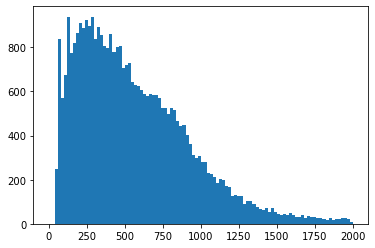

In [5]:
# Extracting appropriate data and transforming to pandas dataframe
df = pd.DataFrame(data)
df_extractive = df[df.density_bin == 'extractive']

# Filtering on rough estimate of lenght text
article_lengths = [len(text.split()) for text in df_extractive.text]
_ = plt.hist(article_lengths, bins = 100, range = (0, 2000))
length_check = [len > 250 for len in article_lengths]
df_extractive = df_extractive[length_check]

# Inspecting head of dataframe for inspection
df_extractive.head()

In [6]:
# Printing the length of the dataset, before and after thinning
print("Full dataset: ", len(df), "\nExtractive dataset: ",len(df_extractive), "\nPercentage: ", round(len(df_extractive)/len(df), 2))

Full dataset:  108837 
Extractive dataset:  28347 
Percentage:  0.26


## Intermidiate Input Representation

In [7]:
# Loading the "en_core_web_sm" model from the SpaCy library
# Disabling unused features for a lighter and more efficient model
# The model is used for text transformation in preprocessing 
nlp = sp.load("en_core_web_sm", disable=["tagger", "parser", "ner", "textcat"])

### Sparse TF-IDF matrix representation

In [8]:
# PREPROCESSING FUNCTION
def preprocess(text):
    # Cleans input text
    text = nlp(text)
    tokens = []
    for token in text:
        # Remove stopwords and numerics, append the lemma form to tokens list
        if token.is_stop == False and token.is_alpha == True:
            tokens.append(token.lemma_)
    
    # Return all lemmatized tokens in the input text
    return tokens

In [9]:
# TF-IDF MATRIX CREATION FUNCTION
def create_tfidf_matrix(corpus, preprocessor = preprocess):
    #Initializing ScikitLearn TF-IDF vectorizer and creating TF-IDF sparse matrix
    vectorizer = TfidfVectorizer(tokenizer = preprocessor)
    tfidf_matrix = vectorizer.fit_transform(corpus['text'])
    
    # Saving list of all corpus tokens
    feature_names = vectorizer.get_feature_names()

    # Inspecting dimension of sparse matrix
    # Rows should equal no. of df_extractive data entities
    # Number of columns equals number of unique corpus tokens
    print("TF-IDF matrix dimension: ", tfidf_matrix.get_shape(), "\nAligning with no. df_extractive enteties? ", tfidf_matrix.get_shape()[0] == len(df_extractive))
    
    # Returning TF-IDF matrix
    return tfidf_matrix, feature_names

### Token and TF-IDF score pairing

In [10]:
# TOKEN TFIDF PAIRING FUNCTION
def token_tfidf_ranking(feature_names, tfidf_matrix, row_index):
    # Exctracting indices of document tokens from the TF-IDF matrix
    token_indices = tfidf_matrix[row_index,:].nonzero()[1]
   
    # Extract token names and pair with corresponding TF-IDF value from the TF-IDF matrix
    # Sort by TF-IDF score
    token_tfidf = pd.DataFrame(np.column_stack(([feature_names[index] for index in token_indices], [tfidf_matrix[row_index, x] for x in token_indices])), columns=['token', 'tfidf_score'])
    token_tfidf = token_tfidf.sort_values(by='tfidf_score', ascending=False)
    
    #token_tfidf = token_tfidf.astype({"word": str, "tfidf_score": float})
    
    # Return the sorted list of (token, TF-IDF value) data frame
    return token_tfidf

### Sentence splitting

In [11]:
# Loading new model from SpaCy and adding sentencizer pipeline
nlp_sentencizer = sp.load("en_core_web_sm", disable=["tagger", "parser", "ner", "textcat"])
nlp_sentencizer.add_pipe(nlp.create_pipe('sentencizer'))

In [12]:
# SENTENCE SPLITTING FUNCTION
def sentence_splitting(doc):
    doc = nlp_sentencizer(doc['text'])
    sentences = [sent.string.strip() for sent in doc.sents]
    
    return sentences

### Sentence level tokenization and scoring

In [13]:
# SENTENCE SCORING FUNTION
def sentence_scoring(sentences, token_tfidf_pairs):
    sentence_scores = []
    
    for i, sentence in enumerate(sentences):
        score = 0
        sentence_length = len(sentence)

        # Using preprocessing function to extract sentence tokens
        sentence_tokens = preprocess(sentence)

        # Summation of sentence tokens' TF-IDF values 
        for token in sentence_tokens:
            token = token.lower()
            if token in token_tfidf_pairs['token'].values:
                score = score + float(token_tfidf_pairs.loc[token_tfidf_pairs['token'] == token]['tfidf_score'].values)

        # Normalizing sentence score dependent on sentence length
        score = score / sentence_length
        
        # Append to list of sentence scores
        sentence_scores.append((i,score))
    
    # Save scores in pd dataframe
    sentence_scores = pd.DataFrame(sentence_scores,columns=["sentence_index", "sentence_score"]).sort_values(by='sentence_score', ascending=False)
    
    # Return final sentence scores
    return sentence_scores 

### Sentence Extraction

In [14]:
# SENTENCE EXTRACTION FUNCTION
def sentence_extraction(sentences, sentence_scores, n):
    summary = []
    
    # Extracting indices of the n number of top scoring sentences
    # sort them in ascending order
    top_sentence_indices = np.sort(sentence_scores[0:n]['sentence_index'].values)
    
    # Extracting the original sentences and appending to summary list
    for index in top_sentence_indices:
        summary.append(sentences[index])
        
    # Joining summary sentences
    summary = ' '.join(summary)
    
    return summary

## Score summaries with ROUGE

In [15]:
# ROUGE SCORING FUNCTION
def rouge_blue_scoring(summaries, references):
    rouge_score = rouge.get_scores(summaries, references)
    return rouge_score
    

# Running the Experiment
* Preprocess and Vectorize
* Extract document's tokens and tfidf key-value pairs
* Sentencize document and score each seperate sentence
* Extract top *n* sentences

In [ ]:
# Intermidiate Input Representation
corpus = df_extractive
corpus.reset_index(inplace = True)
tfidf_matrix, feature_names = create_tfidf_matrix(corpus = corpus)

In [ ]:
# Sentence Scoring and Sentence Extraction
summaries = []

for index, doc in corpus.iterrows():
    token_tfidf_pairs = token_tfidf_ranking(feature_names, tfidf_matrix, index)
    sentences = sentence_splitting(doc)
    sentence_scores = sentence_scoring(sentences, token_tfidf_pairs)
    summary = sentence_extraction(sentences, sentence_scores, 3)
    summaries.append(summary)
    if(index != 0 and index % 1000 == 0):
        print('Checkpoint: ', index)

In [ ]:
# ROUGE Scoring 
rouge = Rouge()
scores = rouge_blue_scoring(summaries, corpus.iloc[0:len(summaries)].summary.values.tolist())
scores_pd = pd.DataFrame(scores)

rouge1_f1_scores = []
rouge1_recall_scores = []
rouge1_precision_scores = []

rouge2_f1_scores = []
rouge2_recall_scores = []
rouge2_precision_scores = []

rougel_f1_scores = []
rougel_recall_scores = []
rougel_precision_scores = []

for i, score in scores_pd.iterrows():
    rouge1_f1_scores.append(score['rouge-1']['f'])
    rouge1_recall_scores.append(score['rouge-1']['r'])
    rouge1_precision_scores.append(score['rouge-1']['p'])
    
    rouge2_f1_scores.append(score['rouge-2']['f'])
    rouge2_recall_scores.append(score['rouge-2']['r'])
    rouge2_precision_scores.append(score['rouge-2']['p'])
    
    rougel_f1_scores.append(score['rouge-l']['f'])
    rougel_recall_scores.append(score['rouge-l']['r'])
    rougel_precision_scores.append(score['rouge-l']['p'])
    
rouge1_f1_average = sum(rouge1_f1_scores)/len(rouge1_f1_scores)
rouge1_recall_average = sum(rouge1_recall_scores)/len(rouge1_recall_scores)
rouge1_precision_average = sum(rouge1_precision_scores)/len(rouge1_precision_scores)

rouge2_f1_average = sum(rouge2_f1_scores)/len(rouge2_f1_scores)
rouge2_recall_average = sum(rouge2_recall_scores)/len(rouge2_recall_scores)
rouge2_precision_average = sum(rouge2_precision_scores)/len(rouge2_precision_scores)

rougel_f1_average = sum(rougel_f1_scores)/len(rougel_f1_scores)
rougel_recall_average = sum(rougel_recall_scores)/len(rougel_recall_scores)
rougel_precision_average = sum(rougel_precision_scores)/len(rougel_precision_scores)


res = {'r1': {'r': rouge1_recall_average, 'p': rouge1_precision_average, 'f1': rouge1_f1_average},
      'r2': {'r': rouge2_recall_average, 'p': rouge2_precision_average, 'f1': rouge2_f1_average},
      'rl': {'r': rougel_recall_average, 'p': rougel_precision_average, 'f1': rougel_f1_average}}

pd.DataFrame(res).to_csv('TFIDF_res.csv')